# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## First validation example: Voxelized sphere

Voxelized spheres are used to test the accuracy and computation time of various methods to compute the surface area. This validation is well suited as
- the surface is analytically known,
- the example is 3D but yet simple,
- the surface is curved and, thus, will suffer from pixelation issues
- many microstructureal features can be approximated as spherical (e.g. pores)

<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/sphere-study/sphere_R2pixel.png" alt="2pixel" width="70" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/sphere-study/sphere_R5pixel.png" alt="5pixel" width="70" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/sphere-study/sphere_R10pixel.png" alt="10pixel" width="70" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/sphere-study/sphere_R20pixel.png" alt="20pixel" width="70" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/sphere-study/sphere_R50pixel.png" alt="50pixel" width="70" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/sphere-study/sphere_R100pixel.png" alt="100pixel" width="70" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/sphere-study/sphere_R200pixel.png" alt="200pixel" width="70" />
</p>

**Author**: Simon Daubner<br>
**Department**: Department of Mechanical Engineering<br>
**Institution**: Karlsruhe Institute of Technology

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import taufactor.metrics as tau
import torch

import metrics
import data
import time

We initialize the grid resolution as

In [2]:
dx = 1.0

Create a list of radii and empty dictionaries to store results:

In [3]:
radii = [2,3,4,5,7,10,20,50,100]

vol_fraction = {'theo':np.zeros(len(radii)), 'num':np.zeros(len(radii))}

methods = ['theo', 'faces', 'marching', 'conv_marching', 'porespy', 'gradient', 'conv_gradient', 'gradient_GPU']
area = {method: np.zeros(len(radii)) for method in methods}
times = {method: np.zeros(len(radii)) for method in methods[1:]}
time_CPU_GPU = np.zeros(len(radii))

Cycle through radii list and perform the following steps
- Create a binary array which contains a voxelized sphere represented by 1 and void by 0. A void layer of 10 cells is added at every boundary.
- Compute the volume fraction based on pixel counting
- Compute the surface area based on various methods and time the computations

In [4]:
count = 0
for Radius in radii:
    sharp_field = data.create_voxelized_sphere(Radius)

    # Optional plotting
    # title = 'Sphere with {} pixel radius'.format(Radius)
    # data.plotField2D(1-sharp_field[:,:,Radius+10], title, dpi=200)

    vol_fraction['theo'][count] = 4/3*np.pi*Radius**3/(sharp_field.size)
    vol_fraction['num'][count] = metrics.volume_fraction(sharp_field, 1)

    timer = []
    area['theo'][count] = 4*np.pi*Radius**2/(np.prod(sharp_field.shape)*dx**3)
    timer.append(time.time())
    area['faces'][count] = 3*tau.surface_area(sharp_field, phases=[1]).item()
    timer.append(time.time())
    area['marching'][count] = metrics.specific_surface_area_marching(sharp_field)
    timer.append(time.time())
    smooth_field = metrics.smooth_with_convolution(sharp_field)
    area['conv_marching'][count] = metrics.specific_surface_area_marching(smooth_field)
    timer.append(time.time())
    area['porespy'][count]  = metrics.specific_surface_area_porespy(sharp_field)
    timer.append(time.time())
    area['gradient'][count] = metrics.specific_surface_area(sharp_field)
    timer.append(time.time())
    area['conv_gradient'][count] = metrics.specific_surface_area(sharp_field, smooth=1)
    timer.append(time.time())

    # Test GPU speed-up using pytorch
    # Separate time measurements for shifting from CPU to GPU and actual computation
    tensor = torch.tensor(sharp_field, dtype=torch.float32)
    tensor = tensor.to('cuda')
    timer.append(time.time())

    grad = torch.gradient(tensor, spacing=(dx,dx,dx))
    norm2 = grad[0].pow(2) + grad[1].pow(2) + grad[2].pow(2)
    surface_area = torch.sum(torch.sqrt(norm2))
    surface_area = surface_area.cpu().item()
    volume = np.prod(sharp_field.shape)
    area['gradient_GPU'][count] = surface_area / volume
    timer.append(time.time())

    for i, method in enumerate(methods[1:]):
        times[method][count] = timer[i+1]-timer[i]

    time_CPU_GPU[count] = timer[7]-timer[6]
    times['gradient_GPU'][count] = timer[8]-timer[7]

    print(f"Finished radius = {Radius}.")
    count = count +1

Finished radius = 2.
Finished radius = 3.
Finished radius = 4.
Finished radius = 5.
Finished radius = 7.
Finished radius = 10.
Finished radius = 20.
Finished radius = 50.
Finished radius = 100.


### Plotting
Plot the results based on following color and line style

In [5]:
colors = ['black', 'red', 'blue', 'purple', 'orange', 'lime', 'green', 'black']
line_styles = ['-', '-', '-.', ':', '--', '-', '-.', ':']

Plot relative volume error

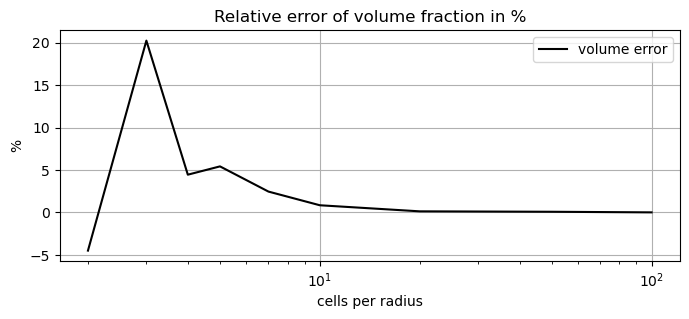

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.semilogx(radii, (vol_fraction['num']-vol_fraction['theo'])/vol_fraction['theo']*100, label='volume error', color=colors[0], linestyle=line_styles[0])

# Add labels, legend, and grid
ax.set_xlabel('cells per radius')
ax.set_ylabel('%')
ax.set_title('Relative error of volume fraction in %')
ax.legend()
ax.grid()

plt.show()

Relative error of surface area computation

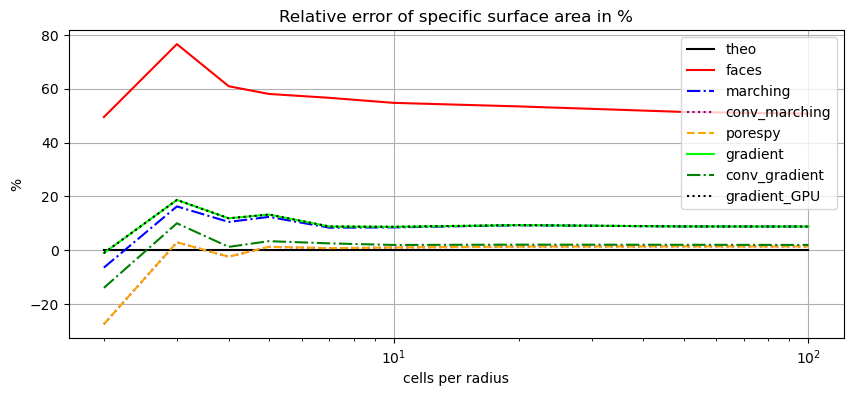

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))

for i, method in enumerate(methods):
    ax.semilogx(radii, (area[method]-area['theo'])/area['theo']*100, label=method, color=colors[i], linestyle=line_styles[i])

ax.set_xlabel('cells per radius')
ax.set_ylabel('%')
ax.set_title('Relative error of specific surface area in %')
ax.legend()
ax.grid()

plt.show()

And, last but not least, the computation times

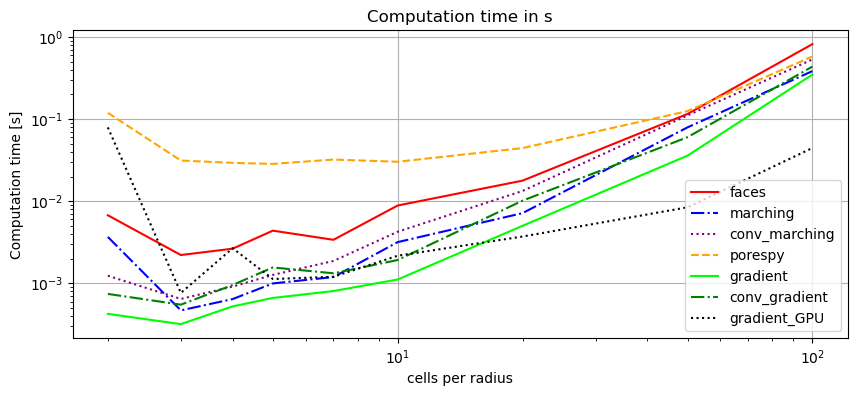

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, method in enumerate(methods[1:]):
    ax.loglog(radii, times[method], label=method, color=colors[i+1], linestyle=line_styles[i+1])
# ax.loglog(radii, time_CPU_GPU, label='CPU2GPU', color='gray', linestyle='-')

ax.set_xlabel('cells per radius')
ax.set_ylabel('Computation time [s]')
ax.set_title('Computation time in s')
ax.legend()
ax.grid()

plt.show()

***
## Appendix: Phase-field solution
Solve phase-field evolution equation for higher accuracy

In [9]:
vol_fraction['PF_eq'] = np.zeros(len(radii))
area['PF_eq']   = np.zeros(len(radii))

count = 0
for Radius in radii:
    sharp_field = data.create_voxelized_sphere(Radius)
    # Blur field as initial condition for phase-field computation
    phase_field = metrics.smooth_with_convolution(sharp_field)

    phase_field = data.solveTwoPhaseWithoutCurvature(phase_field, convergence=0.1, eps=2, stabilize=0.2)
    vol_fraction['PF_eq'][count] = metrics.phase_fraction(phase_field)
    area['PF_eq'][count] = metrics.specific_surface_area(phase_field)

    # print(f"Finished radius = {Radius}.")
    count = count +1

Converged in 74 steps. F_pot/F_grad=0.9051
Converged in 119 steps. F_pot/F_grad=0.9017
Converged in 132 steps. F_pot/F_grad=0.9007
Converged in 138 steps. F_pot/F_grad=0.9002
Converged in 148 steps. F_pot/F_grad=0.9011
Converged in 150 steps. F_pot/F_grad=0.9002
Converged in 153 steps. F_pot/F_grad=0.9010
Converged in 154 steps. F_pot/F_grad=0.9004
Converged in 154 steps. F_pot/F_grad=0.9002


...and plot results in comparison with previous results:

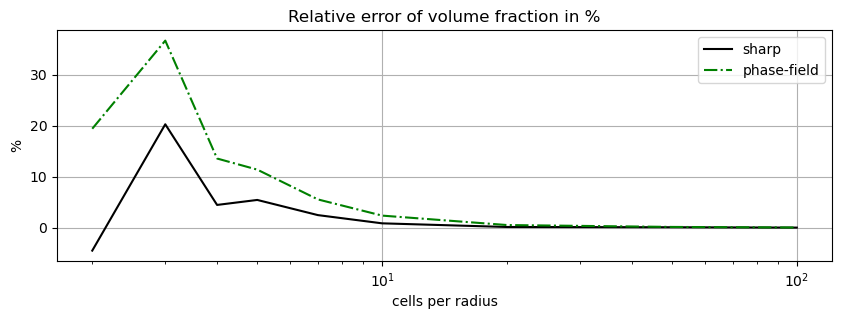

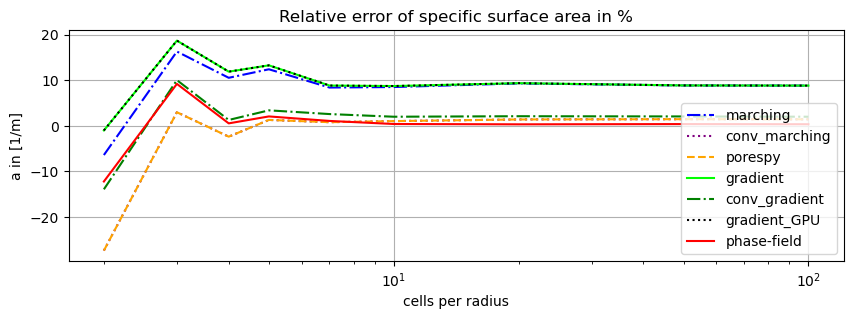

In [10]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 3))
ax.semilogx(radii, (vol_fraction['num']-vol_fraction['theo'])/vol_fraction['theo']*100, label='sharp', color=colors[0], linestyle=line_styles[0])
ax.semilogx(radii, (vol_fraction['PF_eq']-vol_fraction['theo'])/vol_fraction['theo']*100, label='phase-field', color=colors[6], linestyle=line_styles[6])

# Add labels, legend, and grid
ax.set_xlabel('cells per radius')
ax.set_ylabel('%')
ax.set_title('Relative error of volume fraction in %')
ax.legend()
ax.grid()
plt.show()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 3))
for i, method in enumerate(methods[2:]):
    ax.semilogx(radii, (area[method]-area['theo'])/area['theo']*100, label=method, color=colors[i+2], linestyle=line_styles[i+2])
ax.semilogx(radii, (area['PF_eq']-area['theo'])/area['theo']*100,   label='phase-field', color=colors[1], linestyle=line_styles[1])

# Add labels, legend, and grid
ax.set_xlabel('cells per radius')
ax.set_ylabel('a in [1/m]')
ax.set_title('Relative error of specific surface area in %')
ax.legend()
ax.grid()

# Show the plot
plt.show()

We see that the phase-field solution introduces a larger error in the volume fraction for spheres at low resolution. For larger enough features (i.e. spheres with more than ~10 voxels per radius) the phase-field solution achieves higher accuracy for the computation of specific surface area than the previous bestperformers (porespy and convolution+gradient).

***
## Appendix: Save results for external plotting
Write results in dictionaries to text file

In [11]:
file_name = "sphere_pixel_resolution.txt"
results = {'Radius':radii}
for key,s in vol_fraction.items():
    header = 'vol_'+key
    results[header] = s
for key,s in area.items():
    header = 'a_'+key
    results[header] = s
for key,s in times.items():
    header = 't_'+key
    results[header] = s

data.write_dict_to_txt(results, file_name)
print(f"Data written to {file_name}.")

Data written to sphere_pixel_resolution.txt.
